# __Recurrent Neural Network (RNN)__

Recurrent neural networks (RNNs) stand out as a specialized form of neural network. Unlike other neural networks, RNNs introduce a unique mechanism leveraging the output of preceding steps as input for the current step within a sequence. This integration, facilitated by what's termed a hidden state, furnishes RNNs with the invaluable capacity to retain memory of past inputs. Such memory retention proves instrumental in capturing temporal dependencies inherent in sequential data, rendering RNNs indispensable for a broad spectrum of applications spanning natural language processing, speech recognition, and beyond.

In [63]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    classification_report
)
from tensorflow.keras.layers import (
    Embedding, 
    SimpleRNN, 
    Flatten, 
    Dense, 
    Dropout
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# Custom libraries
import sys
sys.path.append('..')
from functions.models import *

In [64]:
train_path = '../data/X_train.tsv'
test_path = '../data/X_test.tsv'
validation_path = '../data/X_val.tsv'

X_train = pd.read_csv(train_path, sep='\t')
X_test = pd.read_csv(test_path, sep='\t')
X_val = pd.read_csv(validation_path, sep='\t')

In [83]:
train_path = '../data/y_train.tsv'
test_path = '../data/y_test.tsv'
validation_path = '../data/y_val.tsv'

y_train = pd.read_csv(train_path, sep='\t')
y_test = pd.read_csv(test_path, sep='\t')
y_val = pd.read_csv(validation_path, sep='\t')

### Tokenization, Padding and Sequencing

In the realm of natural language processing (NLP), tokenization stands as the pivotal process of segmenting a text into smaller entities, which could be words, characters, or even groups of words termed n-grams.

Each unit is then assigned an index to represent it. This allows us to transform a piece of text into a sequence of numbers that a machine learning model can understand.

In [66]:
# Define tokenizer
tokenizer = Tokenizer()
# Fit tokenizer on training data
tokenizer.fit_on_texts(X_train['comment'])

Indexes of each token:

In [67]:
tokenizer.word_index

{'name': 1,
 'like': 2,
 'love': 3,
 'would': 4,
 'good': 5,
 'get': 6,
 'one': 7,
 'people': 8,
 'thanks': 9,
 'really': 10,
 'lol': 11,
 'know': 12,
 'think': 13,
 'thank': 14,
 'time': 15,
 'make': 16,
 'thing': 17,
 'see': 18,
 'hope': 19,
 'much': 20,
 'look': 21,
 'got': 22,
 'sorry': 23,
 'going': 24,
 'year': 25,
 'great': 26,
 'well': 27,
 'want': 28,
 'go': 29,
 'still': 30,
 'even': 31,
 'feel': 32,
 'right': 33,
 'oh': 34,
 'guy': 35,
 'way': 36,
 'never': 37,
 'cannot': 38,
 'game': 39,
 'could': 40,
 'bad': 41,
 'yeah': 42,
 'u': 43,
 'man': 44,
 'need': 45,
 'day': 46,
 'happy': 47,
 'better': 48,
 'say': 49,
 'best': 50,
 'actually': 51,
 'pretty': 52,
 'also': 53,
 'glad': 54,
 'back': 55,
 'sure': 56,
 'wow': 57,
 'though': 58,
 'someone': 59,
 'work': 60,
 'something': 61,
 'thought': 62,
 'take': 63,
 'mean': 64,
 'always': 65,
 'post': 66,
 'yes': 67,
 'hate': 68,
 'first': 69,
 'made': 70,
 'life': 71,
 'wish': 72,
 'nice': 73,
 'help': 74,
 'new': 75,
 'find': 76

Once we have tokenized our text, we need to use the generated tokens to convert the headlines into sequences:

In [68]:
train_sequences = tokenizer.texts_to_sequences(X_train["comment"])
test_sequences = tokenizer.texts_to_sequences(X_test["comment"])
val_sequences = tokenizer.texts_to_sequences(X_val["comment"])

Original headlines

In [72]:
X_train["comment"].values.tolist()[:3]

['everyone think he laugh screwing people instead actually dead',
 'fuck',
 'make feel threatened']

In [73]:

# Sequences
train_sequences[:3]

[[111, 13, 1017, 260, 5383, 8, 365, 51, 437], [81], [16, 32, 2973]]

As it can be noticed, since each headline has a different length, each sequence has also a different length. However, in order to feed the data into the neural network, all the sequences must have the same length. Therefore, we will need to apply some kind of transformation to these sequences to make them all have the same length. For doing so, we will apply a technique called padding.

In [101]:
max_seq_len = max([len(seq) for seq in train_sequences])

In [107]:
train_padded = pad_sequences(train_sequences, maxlen=max_seq_len, padding="post")
val_padded = pad_sequences(val_sequences, maxlen=max_seq_len, padding="post")

In [103]:
# Sequences after padding
train_padded[:3]

array([[ 111,   13, 1017,  260, 5383,    8,  365,   51,  437,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  81,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  16,   32, 2973,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]])

### Model Building

In [104]:
vocab_size = len(tokenizer.word_index) + 1

We create a secuential model, were each layer the layers are stacked on top of each other in a linear sequence.

In [123]:
max_features = vocab_size  
maxlen = max_seq_len  

model = Sequential()
model.add(Embedding(max_features, 100))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.

# Flatten and Dense Layer
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))

model.add(Dense(1, activation="sigmoid"))

In [124]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

### Model Training

In [125]:
history = model.fit(train_padded, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(val_padded, np.array(y_val)))

Epoch 1/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - acc: 0.0572 - loss: -111.3364 - val_acc: 0.0601 - val_loss: -280.5260
Epoch 2/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - acc: 0.0596 - loss: -342.5707 - val_acc: 0.0601 - val_loss: -496.2720
Epoch 3/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - acc: 0.0554 - loss: -559.0023 - val_acc: 0.0601 - val_loss: -711.4042
Epoch 4/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - acc: 0.0580 - loss: -775.3868 - val_acc: 0.0601 - val_loss: -926.2659
Epoch 5/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - acc: 0.0566 - loss: -1002.8516 - val_acc: 0.0601 - val_loss: -1140.6858
Epoch 6/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - acc: 0.0563 - loss: -1223.0426 - val_acc: 0.0601 - val_loss: -1354.9418
Epoch 7/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - acc: 0.0597 - loss: -1435.5597 - val_acc: 0.0601 - val_loss: -1569.2709
Epoch 8/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - acc: 0.0583 - loss: -1659.2096 - val_acc: 0.0601 - val_l

### Model Validation

In [126]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

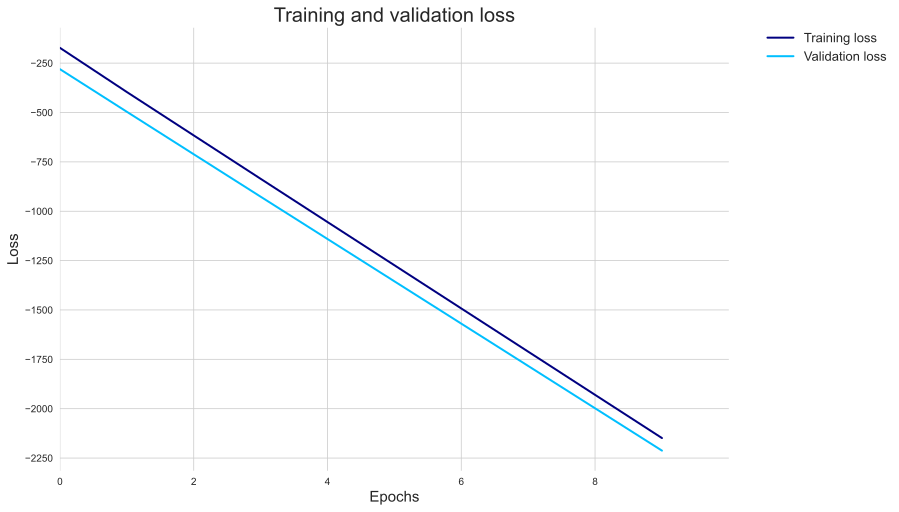

In [127]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "navy", "deepskyblue", "Loss", 2)

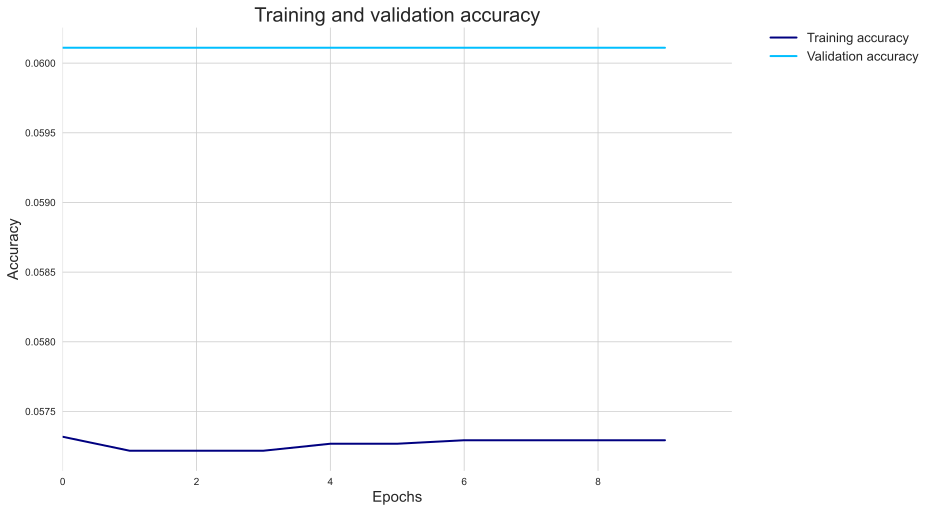

In [128]:
# Plot accuracy curves
plot_metric_curves(epochs, acc, val_acc, "navy", "deepskyblue", "Accuracy", 2)

### Model Evaluation